In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from IPython.display import display, clear_output
import random

%matplotlib inline  

df = pd.read_csv(r"TravisRollsDataset.csv")
df.head()

,id,season,episode,roll,mod,basis,type,adv,critical
0,2,3,1,13,0,wisdom,save,none,none
1,3,3,1,17,0,investigation,check,none,none
2,4,3,1,4,2,dexterity,save,none,none
3,6,3,2,16,7,melee,attack,none,none
4,7,3,2,16,7,melee,attack,advantage,none


In [2]:
def assess_important(x):
    if x['adv']=="disadvantage" or x['basis'] in ["melee", "ranged", "dexterity", "strength"]:
        return 1
    else:
        return 0

df['important'] = df.apply(assess_important, axis=1)

df['rolled'] = pd.Categorical(df.roll.apply(lambda x: "high" if x>10 else "low"), categories=["low", "high"], ordered=True)
df.head()

,id,season,episode,roll,mod,basis,type,adv,critical,important,rolled
0,2,3,1,13,0,wisdom,save,none,none,0,high
1,3,3,1,17,0,investigation,check,none,none,0,high
2,4,3,1,4,2,dexterity,save,none,none,1,low
3,6,3,2,16,7,melee,attack,none,none,1,high
4,7,3,2,16,7,melee,attack,advantage,none,1,high


In [3]:
str_to_num_cols = ["basis", "type", "adv", "critical"]
lookup_encodings = []
for col in str_to_num_cols:
    vals = list(df[col].unique())
    numlist = list(range(len(vals)))
    random.shuffle(numlist)
    tmpdict = dict(zip(vals, numlist))
    lookup_encodings.append(tmpdict)

In [4]:
df_encoded = df.copy()
for i, col in enumerate(str_to_num_cols):
    df_encoded[col] = df_encoded[col].replace(lookup_encodings[i])
df_encoded.head()

,id,season,episode,roll,mod,basis,type,adv,critical,important,rolled
0,2,3,1,13,0,13,2,0,2,0,high
1,3,3,1,17,0,7,3,0,2,0,high
2,4,3,1,4,2,8,2,0,2,1,low
3,6,3,2,16,7,19,0,0,2,1,high
4,7,3,2,16,7,19,0,1,2,1,high


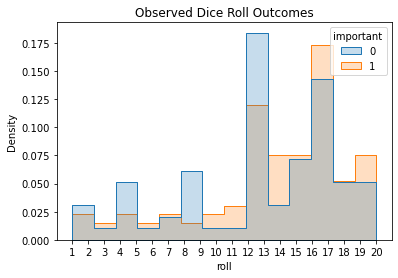

In [5]:
f, ax = plt.subplots()

rollhist = sns.histplot(data=df_encoded, x="roll", hue='important', element="step",
    stat="density", common_norm=False, ax=ax)
rollhist.set_title("Observed Dice Roll Outcomes")
rollhist.set(xticks=list(np.arange(1,21,1)));

A Bayesian Analysis to Update the Likelihood of Dice Outcomes Given Advantage

In [49]:
advantages = pd.DataFrame(df.adv.value_counts()) #count instances by advantage label
advantages['pct'] = advantages.adv / sum(advantages.adv) #find pct of all values
advantages = advantages.iloc[1:].copy() #REMOVE NA ROW

advantages['die_outcomes'] = ["11-20", "1-10"]
#prior probability of die outcomes, either high or low
advantages['prior'] = 1 / 2
#likelihood of advantage/disadvantage states given data
#bayes multiplier, not a probability
advantages['likelihood'] = 1 + advantages.pct #change in representation given adv/disadv

#posterior probability of roll outcome given advantage/disadvantage observations
advantages['posterior'] = (advantages.likelihood * advantages.prior) \
    / sum(advantages.likelihood * advantages.prior)

advantages['per_outcome'] = advantages.posterior / 10

advantages

,adv,pct,die_outcomes,prior,likelihood,posterior,per_outcome
advantage,15,0.088235,11-20,0.5,1.088235,0.51532,0.051532
disadvantage,4,0.023529,1-10,0.5,1.023529,0.48468,0.048468


Based on our existing dataset, advantage and disadvantage are outside the control of the players, and we must assume the base rates of each as a given 

In [61]:
lookupdict = dict(advantages[["die_outcomes", "per_outcome"]].values.tolist())

die_sides = list(range(1,21))
p_adj = [lookupdict["1-10"] if x <11 else lookupdict["11-20"] for x in die_sides]
df_expected = pd.DataFrame(die_sides, columns=["roll"])
df_expected["density"] = p_adj

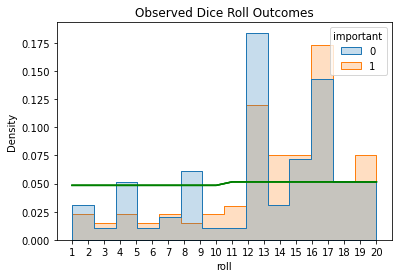

In [62]:
clear_output(wait = True)
ax.plot(die_sides, p_adj, 'g-', label='Expected Density')
display(f);

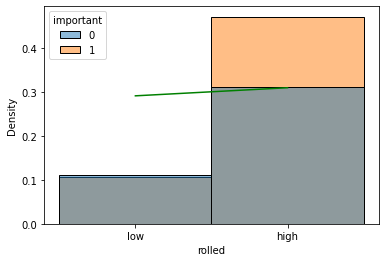

In [63]:
f1, ax1 = plt.subplots()

sns.histplot(data=df_encoded, x="rolled", hue='important',stat="density",ax=ax1)
ax1.plot(["low", "high"], \
         [lookupdict["1-10"]*6,lookupdict["11-20"]*6], \
         'g-', label='Expected Density');

Means testing!! If the dice rolls are fair and random, there should be no difference in means.

$H_0: \mu_1 = \mu_2$  
$H_A: \mu_1 \neq \mu_2$